In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.5.2 (default, Apr 16 2020, 17:47:17) 
[GCC 5.4.0 20160609]
Version info.
sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [2]:
from spectral import *
import spectral.io.aviris as aviris
import matplotlib.pyplot as plt

import torch.nn as nn
from Hyper_loader import Hyper_dataset
import SobelConv
from torch.utils import data
import argparse
import torch
import cv2
import ResNet
from torch.autograd import Variable 
from torchnet.logger import VisdomPlotLogger, VisdomLogger,VisdomTextLogger
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn.init import xavier_normal_ as x_init
from tensorboardX import SummaryWriter
import skimage.measure as skm
import pytorch_ssim
import SpectralResponseFunction

from scipy import ndimage as ndi

import math

from PIL import Image


In [3]:
MseLoss = torch.nn.MSELoss()

def psnr(img1, img2):
    mse = MseLoss(img1, img2)
    if mse == 0:
        return 100
    return 20 * math.log10(1.0 / math.sqrt(mse.item()))

In [4]:
Valdata = Hyper_dataset(output_shape=128, Training_mode='Test', data_name = 'CAVE')
validation_loader = torch.utils.data.DataLoader(Valdata, batch_size=1)

In [5]:
hypernet = ResNet.resnet32().cuda().float()
hyper_point = torch.load("/public/zhanjiang2/models/torch-hyper/epoch_4220.pkl") #/torch-hyper/epoch_4220.pkl
hypernet.load_state_dict(hyper_point)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
sobel = SobelConv.SobelConv().cuda().float()
ssim = pytorch_ssim.SSIM()

[SSIM:0.969686][PSNR:32.383777]
[SSIM:0.941136][PSNR:27.541818]
[SSIM:0.943294][PSNR:26.963737]
[SSIM:0.947237][PSNR:25.855065]
[SSIM:0.946656][PSNR:31.948854]
[SSIM:0.937699][PSNR:27.242876]


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[SSIM:0.959883][PSNR:32.515805]
[SSIM:0.946004][PSNR:29.178796]
[SSIM:0.956049][PSNR:22.906227]
[SSIM:0.937557][PSNR:25.364261]
[SSIM:0.948206][PSNR:29.269678]


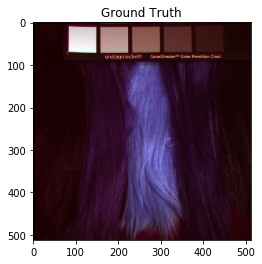

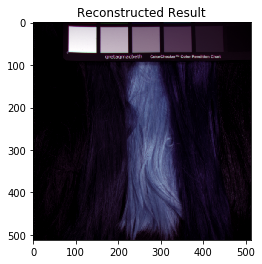

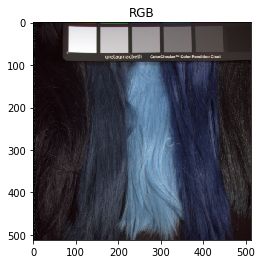

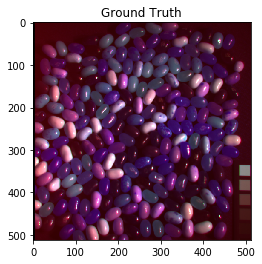

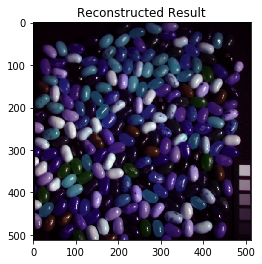

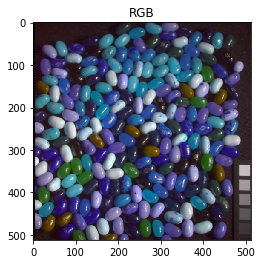

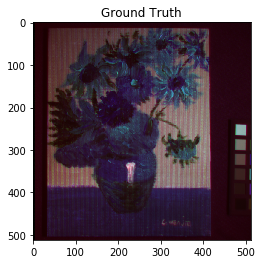

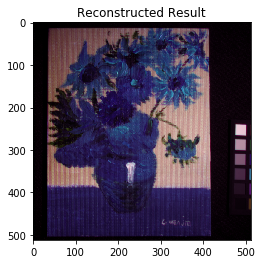

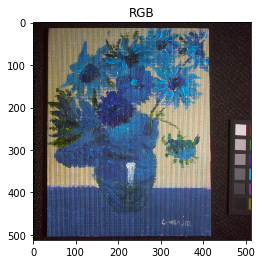

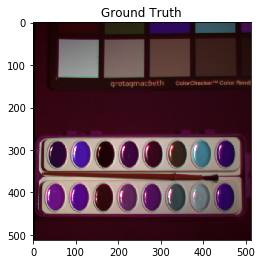

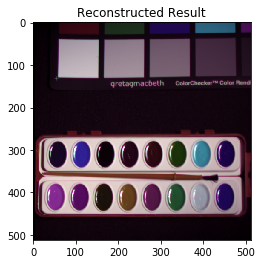

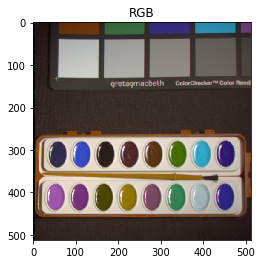

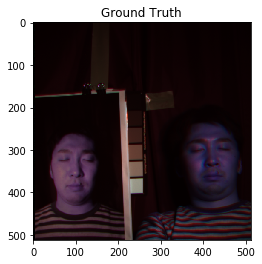

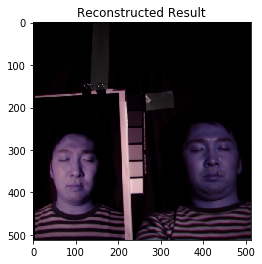

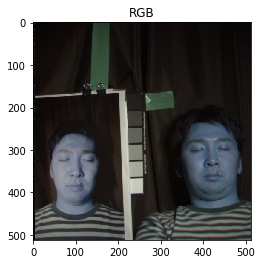

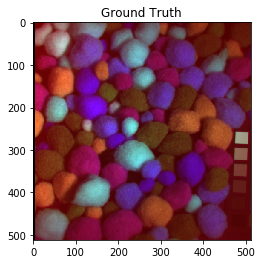

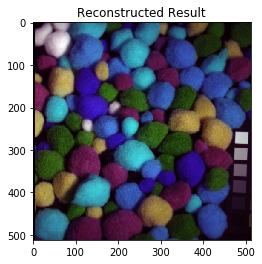

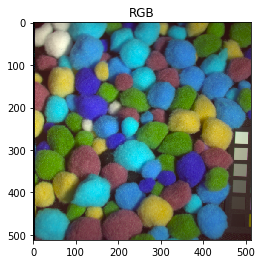

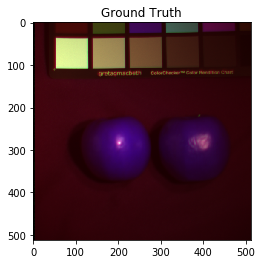

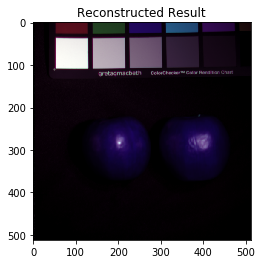

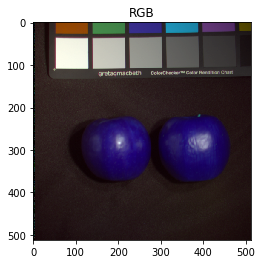

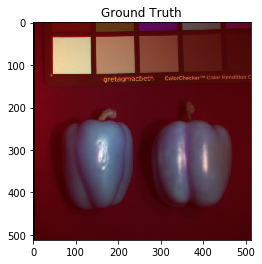

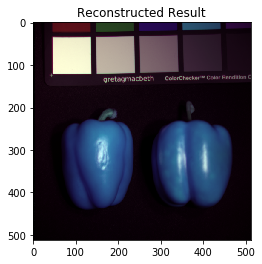

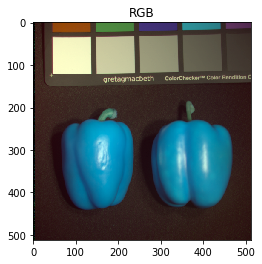

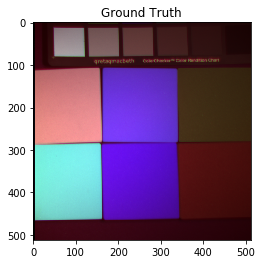

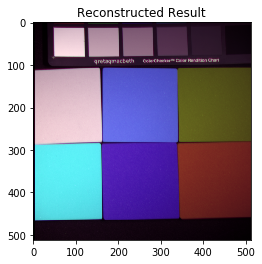

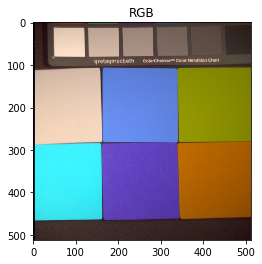

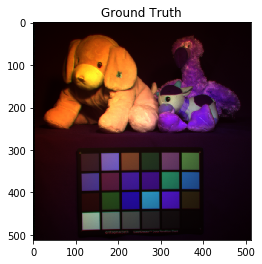

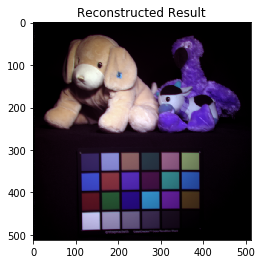

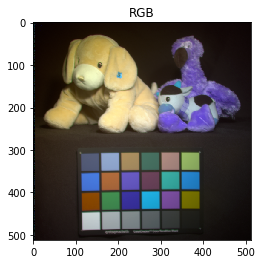

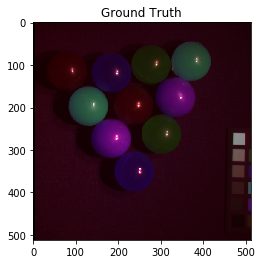

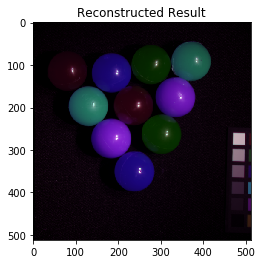

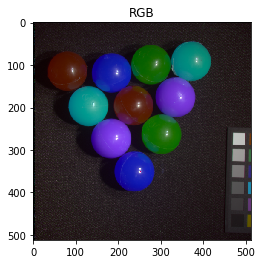

In [6]:
hypernet.eval()
with torch.no_grad():
    for hsi, msi in validation_loader:
        hsi = Variable(hsi.cuda().float(), requires_grad = False)
        msi = Variable(msi.cuda().float(), requires_grad = False)
        x = hypernet(msi)
        output = x.cpu().detach().numpy().astype(np.uint16)
        gt = hsi.cpu().detach().numpy().astype(np.uint16)
        
        view1 = imshow(np.moveaxis(np.squeeze(hsi.cpu().detach().numpy()),0,2))
        view1.set_title("Ground Truth")
        view2 = imshow(np.moveaxis(np.squeeze(x.cpu().detach().numpy()),0,2))
        view2.set_title("Reconstructed Result")
        view3 = imshow(np.moveaxis(np.squeeze(msi.cpu().detach().numpy()),0,2))
        view3.set_title("RGB")

        val_ssim = ssim(x, hsi)
        val_psnr = psnr(x, hsi)
        
        print("[SSIM:%f][PSNR:%f]"%(val_ssim, val_psnr))
        

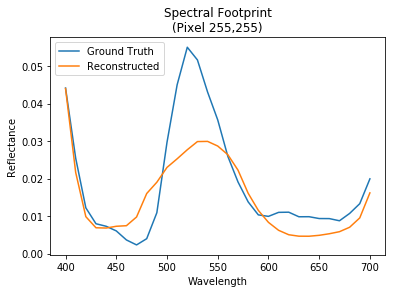

In [7]:
hsi_g = np.moveaxis(np.squeeze(hsi.cpu().detach().numpy()),0,2)
x_g = np.moveaxis(np.squeeze(x.cpu().detach().numpy()),0,2)

pixel_y = 255
pixel_x = 255

pixel_hsi = hsi_g[
    pixel_y:pixel_y+1,
    pixel_x:pixel_x+1,
    :]

pixel_output = x_g[
    pixel_y:pixel_y+1,
    pixel_x:pixel_x+1,
    :]

bands = np.genfromtxt('bands.txt', delimiter=',')

pixel_hsi_squeezed = np.squeeze(pixel_hsi)
pixel_x_squeezed = np.squeeze(pixel_output)

plt.plot(bands, pixel_hsi_squeezed, label="Ground Truth")
plt.plot(bands, pixel_x_squeezed, label="Reconstructed")

plt.legend(loc='upper left')
plt.title('Spectral Footprint\n(Pixel {},{})'.format(
    pixel_x, pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show()


(512, 512, 31)


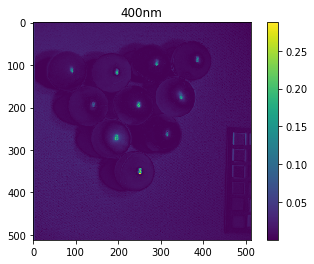

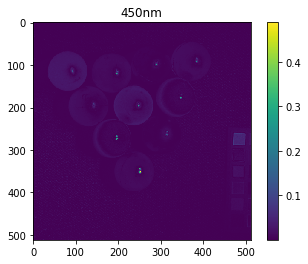

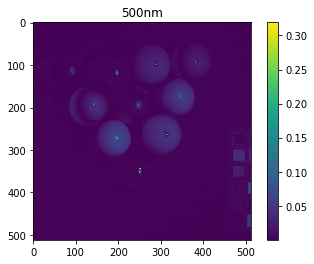

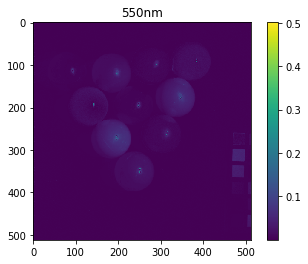

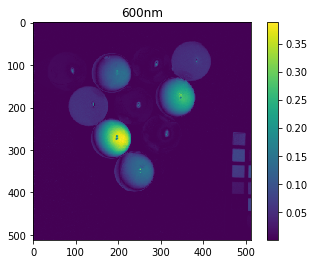

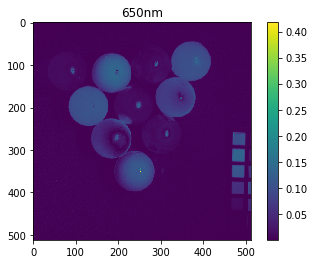

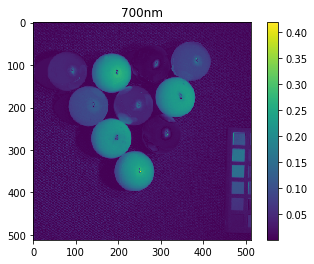

In [8]:
diff = abs(hsi_g - x_g)
print(diff.shape)

for i in [0, 5, 10, 15, 20, 25, 30]:
    fig = plt.figure()
    imgplot = plt.imshow(diff[:,:,i])
    plt.title("{}nm".format(400+i*10))
    plt.colorbar()


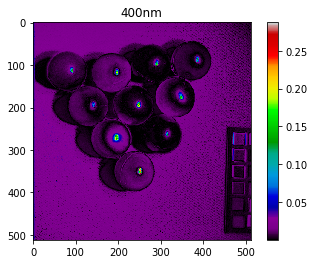

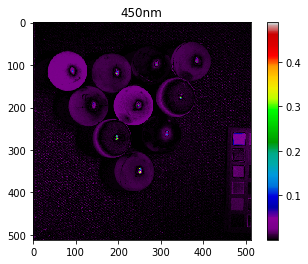

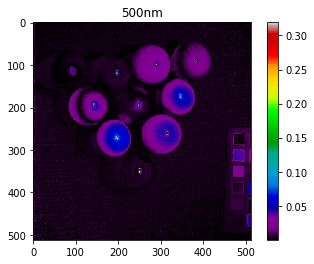

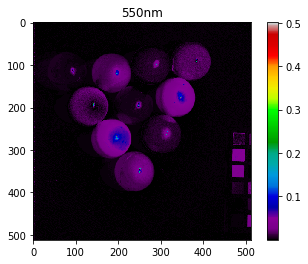

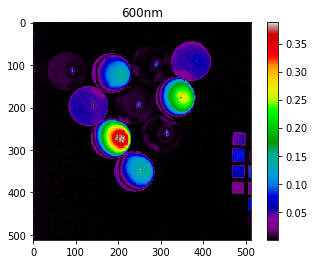

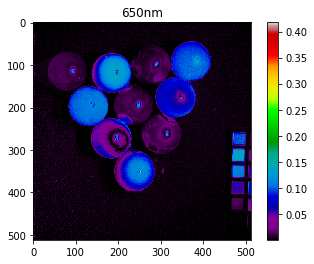

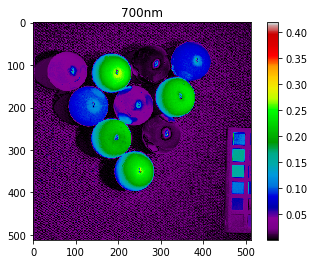

In [9]:
for i in [0, 5, 10, 15, 20, 25, 30]:
    fig = plt.figure()
    imgplot = plt.imshow(diff[:,:,i])
    imgplot.set_cmap('nipy_spectral')
    plt.title("{}nm".format(400+i*10))
    plt.colorbar()
